In [2]:
!pip install statsmodels
!pip install prophet

  Using cached statsmodels-0.14.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 41.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 1.2 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.1 MB/s eta 0:00:00:00:01


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import utils.helpers as helpers

In [22]:
bronx = pd.read_parquet('../data/Bronx - all txns.parquet.gz')
bronx = bronx[['num_txns_All']].reset_index()
bronx['timestamp_hour'] = pd.to_datetime(bronx['timestamp_hour'])
bronx = bronx.sort_values(by = 'timestamp_hour')
bronx = bronx.rename(columns = {'num_txns_All': 'y', 'timestamp_hour': 'ds'})
bronx.head()

,ds,y
0,2019-02-01 00:00:00,1901
1,2019-02-01 01:00:00,1110
2,2019-02-01 02:00:00,772
3,2019-02-01 03:00:00,669
4,2019-02-01 04:00:00,794


In [23]:
bronx.shape

(48931, 2)

In [24]:
bronx_hist = bronx[bronx['ds'] < '2024-08-01']
bronx_test = bronx[bronx['ds']>= '2024-08-01']
bronx_hist.shape, bronx_test.shape

((48187, 2), (744, 2))

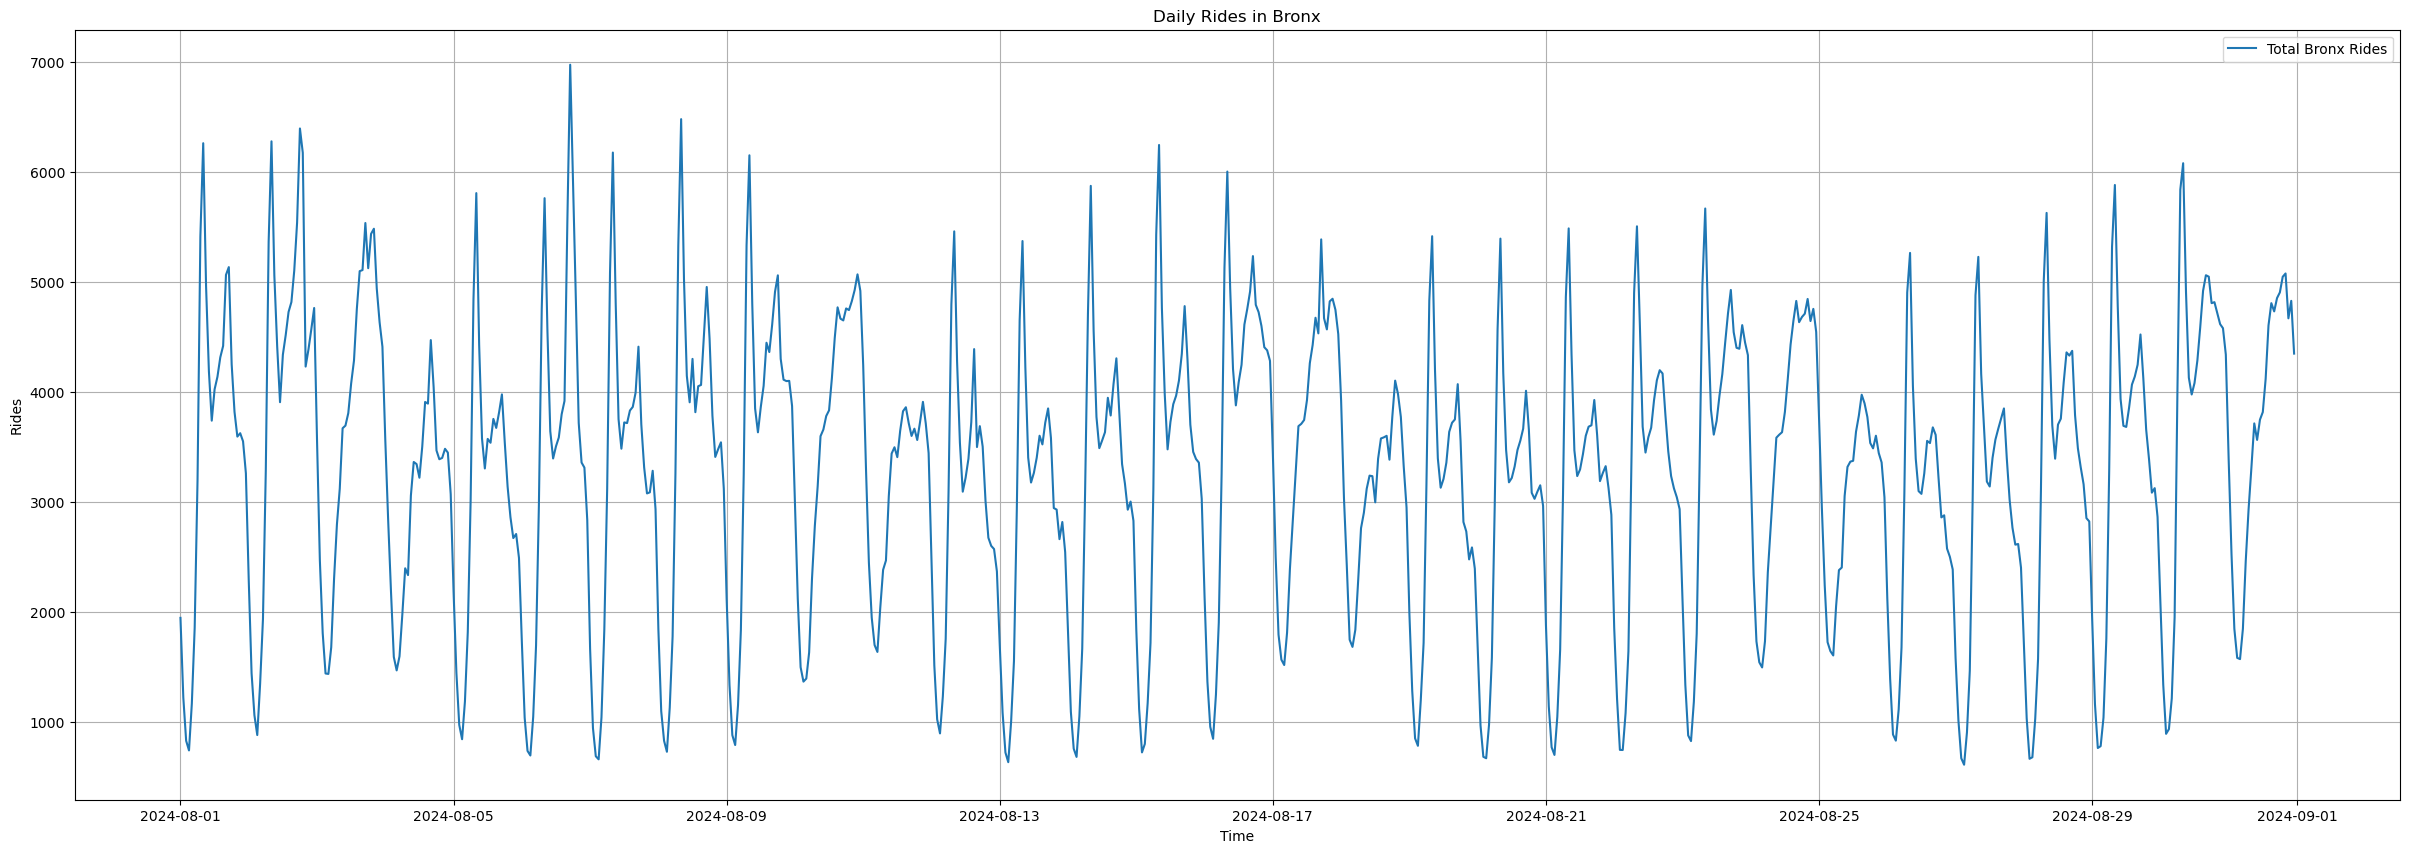

In [26]:
# Plot all 4 columns
plt.figure(figsize=(30, 10))
plt.plot(bronx_test['ds'], bronx_test['y'], label='Total Bronx Rides')

# Customize the plot
plt.title('Daily Rides in Bronx')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
bronx.describe()

,ds,y
count,48931,48931.000000
mean,2021-11-16 11:45:23.451390464,3032.518281
min,2019-02-01 00:00:00,1.000000
25%,2020-06-24 18:30:00,2043.000000
50%,2021-11-16 12:00:00,3164.000000
75%,2023-04-10 05:30:00,3896.000000
max,2024-08-31 23:00:00,9784.000000
std,NaN,1328.425626


In [58]:
from prophet import Prophet

# Initialize Prophet model
model = Prophet(changepoint_prior_scale=0.01)

# Add custom hourly seasonality (you can adjust the period if needed)
#model.add_seasonality(name='hourly', period=24, fourier_order=8)

# Fit the model
model.fit(bronx_hist)

15:21:53 - cmdstanpy - INFO - Chain [1] start processing
15:22:32 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# Predict
forecast = model.predict(df = bronx_test)

# View the forecasted data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
739,2024-08-31 19:00:00,4377.391174,3392.998287,5278.663084
740,2024-08-31 20:00:00,4243.395731,3315.951804,5173.519067
741,2024-08-31 21:00:00,4048.008437,3080.061746,5079.385879
742,2024-08-31 22:00:00,3783.827099,2865.950803,4772.359778
743,2024-08-31 23:00:00,3428.498057,2568.606947,4417.625040


In [60]:
forecast.shape

(744, 22)

In [61]:
__ = helpers.performance_metrics(bronx_test['y'], forecast['yhat'])

MAE: 484.30
MAPE: 17.95%
RMSE: 651.02
R2: 0.76


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 10.0, 100.0],
    'holidays_prior_scale': [1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False]
}

In [ ]:
def evaluate_model(params, train_data, test_data):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        yearly_seasonality=params['yearly_seasonality'],
        weekly_seasonality=params['weekly_seasonality']
    )
    
    model.fit(train_data)
    
    # Make predictions on the test set
    future = model.make_future_dataframe(train_data, periods=len(test_data))
    forecast = model.predict(future)
    
    # Calculate the Mean Absolute Error (MAE)
    y_true = test_data['y'].values
    y_pred = forecast['yhat'][-len(test_data):].values
    mae = mean_absolute_error(y_true, y_pred)
    
    return mae